# Autoregressive (AR) HMM Demo

This notebook demonstrates how to construct and fit a linear autoregressive HMM.
Let $y_t$ denote the observation at time $t$. Let $z_t$ denote the corresponding discrete latent state.

The autoregressive hidden Markov model has the following likelihood,

\begin{align*}
y_t \mid y_{t-1}, z_t &\sim
\mathcal{N}\left(A_{z_t} y_{t-1} + b_{z_t}, Q_{z_t} \right).
\end{align*}

(Higher-order autoregressive processes are also supported.) 

This notebook will also show how inputs are passed into SSMs in Dynamax.

## Setup

In [1]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

### Helper functions for plotting

In [3]:
sns.set_style("white")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

## Manually construct an ARHMM

As in the Gaussian HMM demo, we first construct a transition matrix so that state $k$ transitions to itself with high probaability and progresses to state $\mathrm{mod}(k+1, K)$ otherwise. 

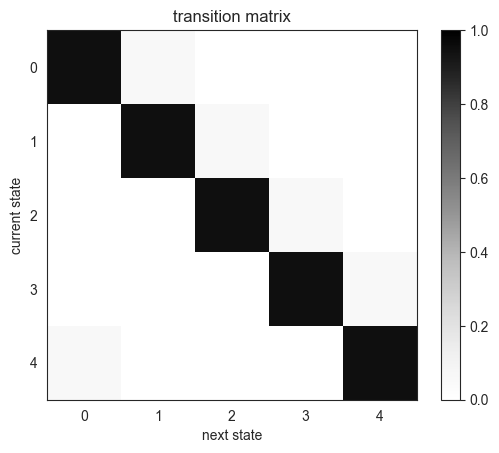

In [4]:
# Make a transition matrix
num_states = 5
transition_probs = (jnp.arange(num_states)**10).astype(float)
transition_probs /= transition_probs.sum()
transition_matrix = jnp.zeros((num_states, num_states))
for k, p in enumerate(transition_probs[::-1]):
    transition_matrix += jnp.roll(p * jnp.eye(num_states), k, axis=1)
    
plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.xlabel("next state")
plt.ylabel("current state")
plt.title("transition matrix")
plt.colorbar()

### Construct and plot the autoregressive dynamics distributions

Each emission distribution corresponds to a linear dynamical system,
\begin{align*}
p(y_t \mid y_{t-1}, z_t=k) &= \mathrm{N}(y_t \mid A_k y_{t-1} + b_k, Q_k)
\end{align*}
with dynamics weights $A_k$, bias $b_k$, and covariance $Q_k$. 

The plots below show the dynamics functions, $f_k(y_{t-1}) = A_k y_{t-1} + b_k$, for each state $k$. When $y \in \mathbb{R}^2$, we can visualize these dynamics functions as flow fields. Here, we have constructed the dynamics so that each state spirals in toward a fixed point, and the fixed points are arranged on a circle. 

In [5]:
# Make emission distributions
emission_dim = 2
num_lags = 1

keys = jr.split(jr.PRNGKey(0), num_states)
angles = jnp.linspace(0, 2 * jnp.pi, num_states, endpoint=False)
theta = jnp.pi / 25 # rotational frequency
weights = jnp.array([0.8 * random_rotation(key, emission_dim, theta=theta) for key in keys])
biases = jnp.column_stack([jnp.cos(angles), jnp.sin(angles), jnp.zeros((num_states, emission_dim - 2))])
covariances = jnp.tile(0.001 * jnp.eye(emission_dim), (num_states, 1, 1))

# Compute the stationary points
stationary_points = jax.vmap(jnp.linalg.solve)(jnp.eye(emission_dim) - weights, biases)

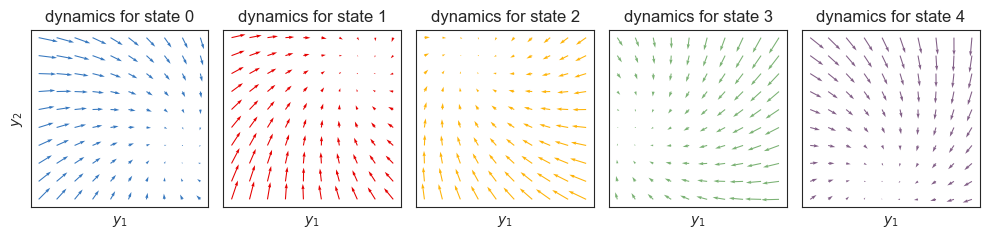

In [6]:
if emission_dim == 2:
    lim = 5
    x = jnp.linspace(-lim, lim, 10)
    y = jnp.linspace(-lim, lim, 10)
    X, Y = jnp.meshgrid(x, y)
    xy = jnp.column_stack((X.ravel(), Y.ravel()))

    fig, axs = plt.subplots(1, num_states, figsize=(2 * num_states, 4))
    for k in range(num_states):
        A, b = weights[k], biases[k]
        dxydt_m = xy.dot(A.T) + b - xy
        axs[k].quiver(xy[:, 0], xy[:, 1],
                    dxydt_m[:, 0], dxydt_m[:, 1],
                    color=colors[k % len(colors)])

        
        axs[k].set_xlabel('$y_1$')
        axs[k].set_xticks([])
        if k == 0:
            axs[k].set_ylabel("$y_2$")
        axs[k].set_yticks([])
        axs[k].set_aspect("equal")
        axs[k].set_title(f"dynamics for state {k}")
                        

    plt.tight_layout()

```{note} Fixed Points of a Linear Dynamical System
A fixed point of a stable, deterministic linear dynamical system (if one exists) is a point where
\begin{align*}
f_k(y^star) &= y^star
\Rightarrow (I - A_k) y^\star = b_k
\end{align*}
If $(I - A_k)$ is invertible, then there is a unique fixed point. If the eigenvalues of $A_k$ have magnitude less than one, then the fixed point is stable. 

When you add noise to the states at each time step, then it becomes a stochastic process and there is no longer a static fixed point. Instead, the system can converge to a stationary distribution around the fixed point of the deterministic system, as you see in the sampled trajectories below.
```

## Sample emissions from the ARHMM

Finally, let's sample from the model. Like the Gaussian HMM in the previous example, the states switch from blue to red to yellow and so on, progressing around the circle. Unlike the simple Gaussian HMM, however, here the states move from one cluster center to another according to the spiraling dynamics of the flow fields above. 

In [7]:
# Make an Autoregressive (AR) HMM
true_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
true_params, _ = true_arhmm.initialize(initial_probs=jnp.ones(num_states) / num_states,
                                       transition_matrix=transition_matrix,
                                       emission_weights=weights,
                                       emission_biases=biases,
                                       emission_covariances=covariances)

time_bins = 10000
true_states, emissions = true_arhmm.sample(true_params, jr.PRNGKey(0), time_bins)

# Compute the lagged emissions (aka inputs)
inputs = true_arhmm.compute_inputs(emissions)

Text(0.5, 1.0, 'Sampled trajectory from an AR-HMM, color-coded by discrete state')

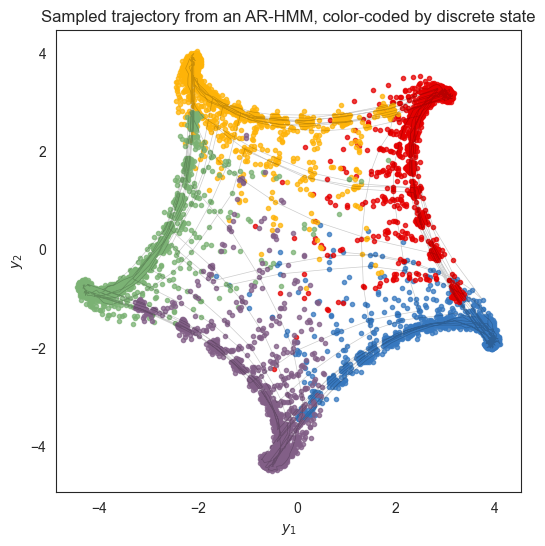

In [8]:
# Plot the sampled data
fig = plt.figure(figsize=(6, 6))
for k in range(num_states):
    plt.plot(*emissions[true_states==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)
    
plt.plot(*emissions[:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$y_1$")
plt.ylabel("$y_2$")
plt.title("Sampled trajectory from an AR-HMM, color-coded by discrete state")

Below, we visualize each component of of the observation variable as a time series. The colors correspond to the latent state. The dotted lines represent the stationary point of the autoregressive process for state $k$ (see note above), while the solid lines are the actual observations sampled from the HMM.

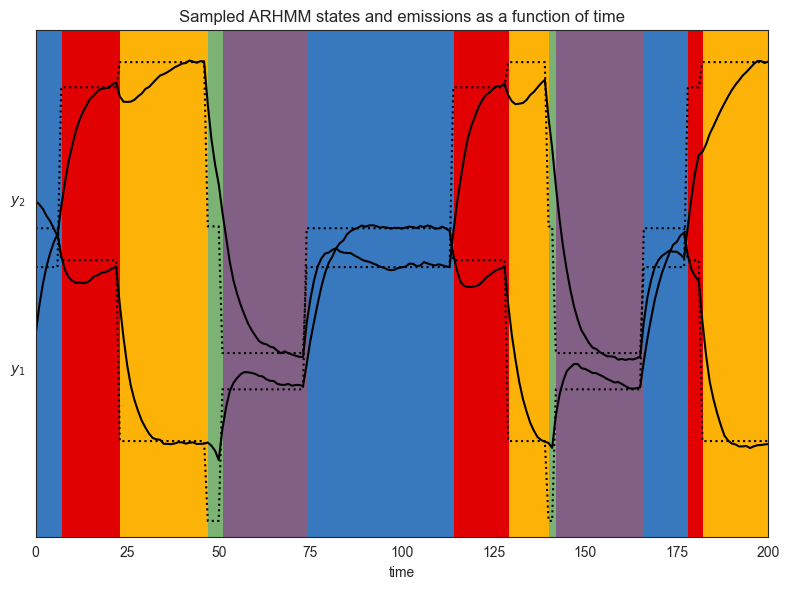

In [9]:
# Plot the emissions and the smoothed emissions
plot_slice = (0, 200)
lim = 1.05 * abs(emissions).max()
plt.figure(figsize=(8, 6))
plt.imshow(true_states[None, :],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (emission_dim)*lim))


Ey = jnp.array(stationary_points)[true_states]
for d in range(emission_dim):
    plt.plot(emissions[:,d] + lim * d, '-k')
    plt.plot(Ey[:,d] + lim * d, ':k')

plt.xlim(plot_slice)
plt.xlabel("time")
plt.yticks(lim * jnp.arange(emission_dim), ["$y_{{{}}}$".format(d+1) for d in range(emission_dim)])
plt.title("Sampled ARHMM states and emissions as a function of time")
plt.tight_layout()


## Fit an ARHMM

Now that we've sampled data from a true model, let's see if we can recover the states and parameters using EM.

In [10]:
# Now fit an HMM to the emissions
key1, key2 = jr.split(jr.PRNGKey(0), 2)
test_num_states = num_states

# Initialize with K-Means
arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)

# Fit with EM
fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs)

### Plot the log likelihoods against the true likelihood, for comparison

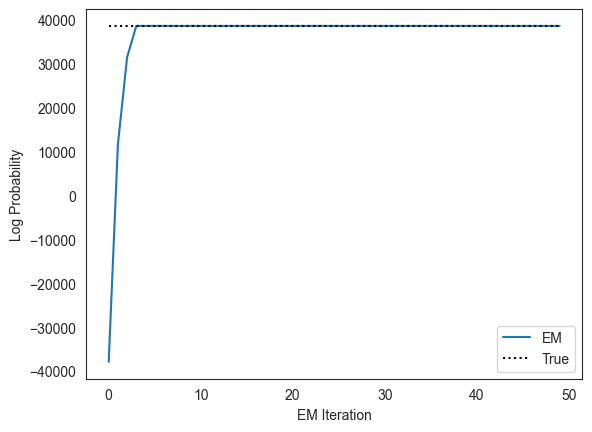

In [11]:
true_lp = true_arhmm.marginal_log_prob(true_params, emissions, inputs=inputs)
plt.plot(lps, label="EM")
plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

### Plot the true inferred dynamics


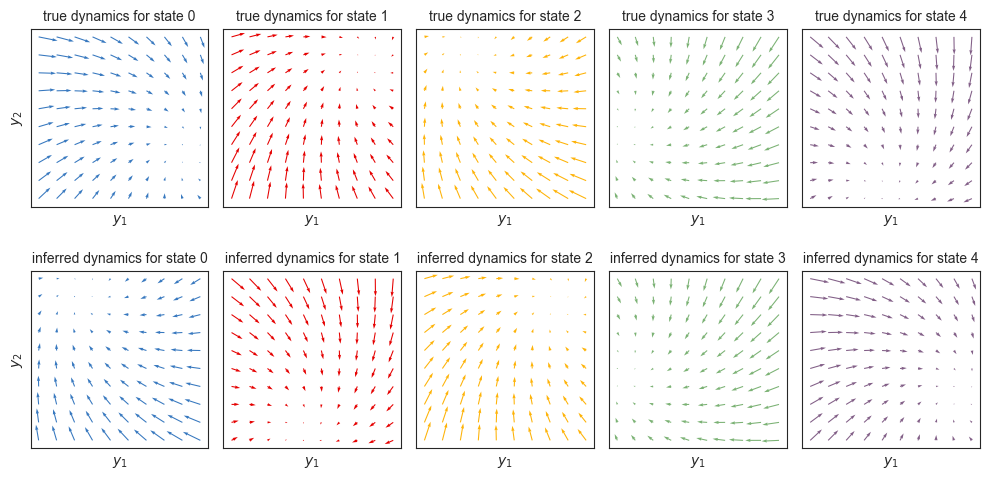

In [13]:
if emission_dim == 2:
    lim = abs(emissions).max()
    x = jnp.linspace(-lim, lim, 10)
    y = jnp.linspace(-lim, lim, 10)
    X, Y = jnp.meshgrid(x, y)
    xy = jnp.column_stack((X.ravel(), Y.ravel()))

    fig, axs = plt.subplots(2, max(num_states, test_num_states), figsize=(2 * num_states, 5))
    for i, params in enumerate([true_params, fitted_params]):
        for j in range(num_states):
            A = params.emissions.weights[j]
            b = params.emissions.biases[j]
            dxydt_m = xy.dot(A.T) + b - xy
            axs[i,j].quiver(xy[:, 0], xy[:, 1],
                        dxydt_m[:, 0], dxydt_m[:, 1],
                        color=colors[j % len(colors)])


            axs[i,j].set_xlabel('$y_1$')
            axs[i,j].set_xticks([])
            if j == 0:
                axs[i,j].set_ylabel("$y_2$")
            axs[i,j].set_yticks([])
            axs[i,j].set_aspect("equal")
            axs[i,j].set_title(f"{'true' if i==0 else 'inferred'} dynamics for state {j}",
                               fontsize=10)
                        

    plt.tight_layout()

As in the Gaussian HMM notebook, we see that the inferred dynamics closely match the true dynamics, up to label switching. Again, we could find the best permutation to align true and inferred states using the `find_permutation` function described in the Gaussian HMM notebook.

### Plot the true and inferred discrete states

Now let's look at the posterior distribution over the latent states. We should see that the inferred states switch at the same time as the true states, but the labels of the states may be different.

In [17]:
# Compute the posterior distribution of the latent states
posterior = arhmm.smoother(fitted_params, emissions, inputs=inputs)

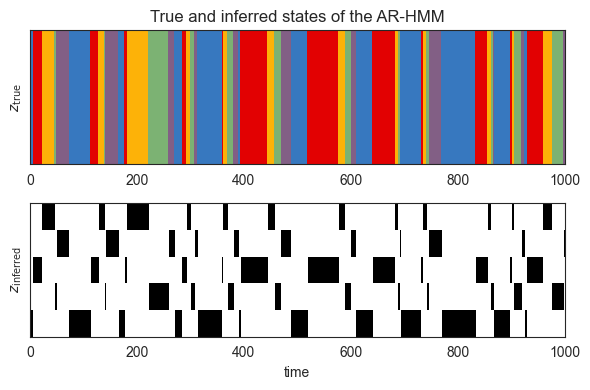

In [19]:

# Plot the true states and the posterior probability 
plot_slice = (0, 1000)
plt.figure(figsize=(6, 4))
plt.subplot(211)
plt.imshow(true_states[None,num_lags:], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.title("True and inferred states of the AR-HMM")

plt.subplot(212)
plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

## Sample new data from the fitted model

A good (and difficult!) test of a generative model is its ability to simulate data that looks like the real data. Let's simulate new data from an ARHMM with the fitted parameter and see what it looks like.


In [15]:
sampled_states, sampled_emissions = arhmm.sample(fitted_params, jr.PRNGKey(0), time_bins)

Text(0.5, 1.0, 'Sampled trajectory from a fitted AR-HMM, color-coded by discrete state')

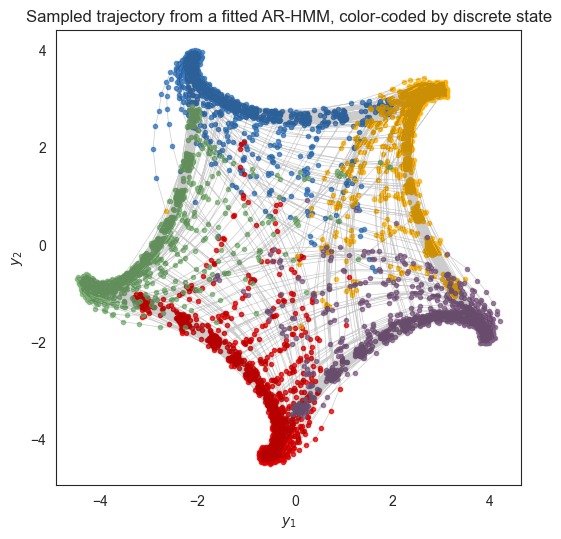

In [16]:
fig = plt.figure(figsize=(6, 6))
for k in range(test_num_states):
    plt.plot(*sampled_emissions[sampled_states==k].T, 'o', color=colors[k % len(colors)],
         alpha=0.75, markersize=3)
    
plt.plot(*sampled_emissions.T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$y_1$")
plt.ylabel("$y_2$")
plt.gca().set_aspect("equal")
plt.title("Sampled trajectory from a fitted AR-HMM, color-coded by discrete state")

## Conclusion

This notebook showed how to sample and fit an autoregressive HMM. These models can produce complex multivariate time series by switching between different autoregressive regimes. In this model, the each discrete state has _linear_ autoregressive dynamics, but one could imagine extending this model to _nonlinear_ dynamics (perhaps in a future version of Dynamax!). For now, this notebook should provide a good launchpad for fitting ARHMMs to real data.